In [2]:
%matplotlib inline
import numpy as np
import nengo
import pylab

Simulation finished in 0:00:04.                                                 


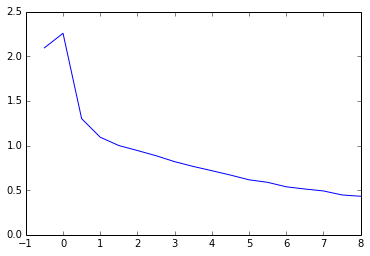

In [140]:

model = nengo.Network()
model.config[nengo.Ensemble].max_rates = nengo.dists.Uniform(40,80)
with model:
    stim = nengo.Node(lambda t: 1 if 0<t<1 else 0)
    
    sensory = nengo.Ensemble(n_neurons=100, dimensions=1)
    
    D = 1
    spike_noise=0.01
    memory = nengo.Ensemble(n_neurons=500, dimensions=D, 
                            noise=nengo.processes.WhiteNoise(
                                    dist=nengo.dists.Gaussian(mean=0, std=spike_noise)))
    
    nengo.Connection(stim, sensory, synapse=None)
    nengo.Connection(sensory, memory[0], synapse=0.01)
    nengo.Connection(memory, memory, synapse=0.1)
    
    p_mem = nengo.Probe(memory, synapse=0.1, sample_every=0.5)
    
sim = nengo.Simulator(model)
sim.run(9)

pylab.plot(sim.trange(dt=0.5)-1, sim.data[p_mem][:,0])
pylab.show()

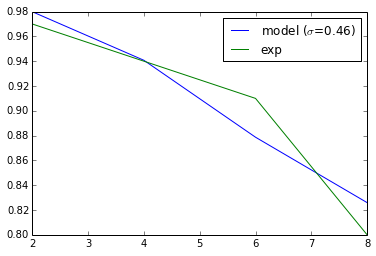

[[ 0.00078491]]
0.000437833432639


In [146]:
import scipy.stats

def prob(x, noise=1.0):
    return scipy.stats.norm.cdf(x/noise)

values = sim.data[p_mem][[5,9,13,17],0]   # model data

data = [0.97, 0.94, 0.91, 0.80]           # experimental data

def curve(x, noise):
    return prob(values, noise=noise)

import scipy.optimize
p, err = scipy.optimize.curve_fit(curve, np.arange(3), data)

pylab.plot([2,4,6,8], curve(0, *p), label='model ($\sigma$=%0.2f)' % p[0])
pylab.plot([2,4,6,8], data, label='exp')
pylab.legend(loc='best')
pylab.show()

print err
print np.sqrt(np.mean((curve(0, *p)-data)**2))**2

In [148]:
import scipy.stats

def prob(x, noise=1.0):
    return scipy.stats.norm.cdf(x/noise)

def evaluate(n_neurons=100, D=8, max_rate=80, stim_mag=1, spike_noise=0.01, synapse_memory=0.1):

    model = nengo.Network()
    model.config[nengo.Ensemble].max_rates = nengo.dists.Uniform(max_rate/2,max_rate)
    with model:
        stim = nengo.Node(lambda t: stim_mag if 0<t<1 else 0)

        sensory = nengo.Ensemble(n_neurons=100, dimensions=1)

        memory = nengo.Ensemble(n_neurons=n_neurons, dimensions=D, 
                                noise=nengo.processes.WhiteNoise(
                                        dist=nengo.dists.Gaussian(mean=0, std=spike_noise)))

        nengo.Connection(stim, sensory, synapse=None)
        nengo.Connection(sensory, memory[0], synapse=0.01)
        nengo.Connection(memory, memory, synapse=synapse_memory)

        p_mem = nengo.Probe(memory, synapse=0.1, sample_every=0.5)

    sim = nengo.Simulator(model)
    sim.run(9)

    values = sim.data[p_mem][[5,9,13,17],0]   # model data
    data = [0.97, 0.94, 0.91, 0.80]           # experimental data

    def curve(x, noise):
        return prob(values, noise=noise)

    import scipy.optimize
    p, err = scipy.optimize.curve_fit(curve, np.arange(3), data)
    
    rmse = np.sqrt(np.mean((curve(0, *p)-data)**2))
    choice_noise = p[0]
    
    return dict(rmse=rmse, 
                choice_noise=p[0],
                values=values)

print evaluate()

Simulation finished in 0:00:08.                                                 
{'values': array([ 0.58159807,  0.53053696,  0.581165  ,  0.53160493]), 'choice_noise': 0.42517596452169726, 'rmse': 0.059477588488203906}
